### 聽完一天半的 R， 手應該會很癢

### 據說今年沒資料分析，那只好閃電分析一下

### 那在聽完R爬蟲要幹嘛？ 當然要文字分析一下

In [3]:
options(warn=-1)     # 環境設定
library(jiebaR)      # 斷詞利器
library(tm)          # 文字詞彙矩陣運算
library(slam)        # 稀疏矩陣運算
library(wordcloud)   # 文字雲
library(topicmodels) # 主題模型
library(igraph)      # 主題模型關聯

Loading required package: jiebaRD
Loading required package: NLP
Loading required package: RColorBrewer

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [7]:
# 起手式，結巴建立斷詞器
mixseg = worker()

In [8]:
# 常用操作函數化，讀資料檔用
readSpeaker <- function(file,sep){
    lines <- readLines(file)
    allString <- do.call(paste,as.list(lines))
    sepString <- strsplit(allString,sep,fixed=TRUE)
    return(sepString[[1]])
}

### 不知道明天想去那場議程，那來分析明後天議程好了？

### 網頁上好像有資料，只好爬下來玩一下
[2015資料科學愛好者年會](http://datasci.tw/speaker.php)

In [9]:
# 講者清單
speakers <- readSpeaker("speaker.txt",sep="-----")
length(speakers);speakers[1]

[1] 27

[1] "陳昇瑋 Sheng-Wei Chen 年會總召, 中央研究院資訊科學研究所/ 研究員 陳昇瑋博士目前為中央研究院資訊科學研究所研究員，同時是多媒體網路與系統實驗室主持人。他的研究焦點著重在使用者滿意度、多媒體系統、社群計算及計算社會學等領域，在多媒體系統及使用者經驗的量測及管理方面持續有代表性的研究創見。  陳博士堅信資料及資料分析的價值，長期推廣資料科學及其在各領域的應用，除本身研究皆基於資料來解決實際生活中的問題，2014 年開始主辦「台灣資料科學愛好者年會」，期能將對於資料科學的熱情傳達給大眾，一起來探索資料科學的潛力，將資料科學引入每個人的專業領域之中。他十分期待能夠讓資料分析在台灣不再是口號，而是大家手邊隨時可用來解決問題及創造價值的工具。  欲瞭解陳博士的研究及心得分享，請至他的個人網頁一探究竟。  "

In [10]:
# 第一位講者分的如何？
first_speaker <- mixseg <= speakers[1]
first_speaker

[1] "陳"         "昇"         "瑋"         "Sheng"      "Wei"       
  [6] "Chen"       "年會"       "總召"       "中央研究院" "資訊"      
 [11] "科學"       "研究所"     "研究員"     "陳"         "昇"        
 [16] "瑋"         "博士"       "目前"       "為"         "中央研究院"
 [21] "資訊"       "科學"       "研究所"     "研究員"     "同時"      
 [26] "是"         "多媒體"     "網路"       "與"         "系統"      
 [31] "實驗室"     "主持人"     "他"         "的"         "研究"      
 [36] "焦點"       "著重"       "在"         "使用者"     "滿意度"    
 [41] "多媒體系統" "社群"       "計算"       "及"         "計算"      
 [46] "社會學"     "等"         "領域"       "在"         "多媒體系統"
 [51] "及"         "使用者"     "經驗"       "的"         "量"        
 [56] "測及"       "管理方面"   "持續"       "有"         "代表性"    
 [61] "的"         "研究"       "創見"       "陳博士"     "堅信"      
 [66] "資料"       "及"         "資料"       "分析"       "的"        
 [71] "價值"       "長期"       "推廣"       "資料"       "科學"      
 [76] "及其"       "在"         "各"         "領域"       "的"        
 [81] "應用"       "除"         "本身"       "研究"       "皆"        
 [86] "基於"       "資料"       "來"         "解決"       "實際"      
 [91] "生活"       "中"         "的"         "問題"       "2014"      
 [96] "年"         "開始"       "主辦"       "台灣"       "資料"      
[101] "科學"       "愛好者"     "年會"       "期能將"     "對於"      
[106] "資料"       "科學"       "的"         "熱情"       "傳達"      
[111] "給大眾"     "一"         "起來"       "探索"       "資料"      
[116] "科學"       "的"         "潛力"       "將"         "資料"      
[121] "科學"       "引入"       "每個"       "人"         "的"        
[126] "專業"       "領域"       "之中"       "他"         "十分"      
[131] "期待"       "能夠"       "讓"         "資料"       "分析"      
[136] "在"         "台灣"       "不再"       "是"         "口號"      
[141] "而是"       "大家"       "手邊"       "隨時"       "可"        
[146] "用來"       "解決問題"   "及"         "創造"       "價值"      
[151] "的"         "工具"       "欲瞭解"     "陳博士"     "的"        
[156] "研究"       "及"         "心得"       "分享"       "請"        
[161] "至"         "他"         "的"         "個人"       "網頁"      
[166] "一探"       "究竟"

In [11]:
# 自幹一下斷詞過濾器(內建用perl的 regular expression 有bug！！！！！！！)
cutter <- function(msg){
    filter_words = c("的","在","與","及","等","是","the","and","in","a","at","he","is","of","He")
    pattern <- sprintf("[^%s]", paste(filter_words, collapse = "|^"))
    filter_seg <- grep(pattern, mixseg <= msg ,value=TRUE)
  return(filter_seg)
}

In [12]:
# 再把每篇文章向量化
segRes = lapply(speakers,cutter)
tmWordsVec = sapply(segRes,function(ws) paste(ws,collapse = " "))
tmWordsVec[1]

[1] "陳 昇 瑋 Sheng Wei Chen 年會 總召 中央研究院 資訊 科學 研究所 研究員 陳 昇 瑋 博士 目前 為 中央研究院 資訊 科學 研究所 研究員 同時 多媒體 網路 系統 實驗室 主持人 他 研究 焦點 著重 使用者 滿意度 多媒體系統 社群 計算 計算 社會學 領域 多媒體系統 使用者 經驗 量 測及 管理方面 持續 有 代表性 研究 創見 陳博士 堅信 資料 資料 分析 價值 長期 推廣 資料 科學 及其 各 領域 應用 除 本身 研究 皆 基於 資料 來 解決 實際 生活 中 問題 2014 年 開始 主辦 台灣 資料 科學 愛好者 年會 期能將 對於 資料 科學 熱情 傳達 給大眾 一 起來 探索 資料 科學 潛力 將 資料 科學 引入 每個 人 專業 領域 之中 他 十分 期待 能夠 讓 資料 分析 台灣 不再 口號 而是 大家 手邊 隨時 可 用來 解決問題 創造 價值 工具 欲瞭解 陳博士 研究 心得 分享 請 至 他 個人 網頁 一探 究竟"

In [13]:
# 文字探勘基本結構，語料庫 & TDM
corpus <- Corpus(VectorSource(tmWordsVec))
tdm = TermDocumentMatrix(corpus,control = list(wordLengths = c(1, Inf)))
tdm

<<TermDocumentMatrix (terms: 1291, documents: 27)>>
Non-/sparse entries: 2001/32856
Sparsity           : 94%
Maximal term length: 14
Weighting          : term frequency (tf)

In [14]:
# 看看一下詞頻分的如何 (因為看到分的不好才弄個過濾器的)
dtm1 <- DocumentTermMatrix(corpus,
                           control = list(
                             wordLengths=c(1, Inf), # to allow long words
                             removeNumbers = TRUE, 
                             weighting = weightTf, 
                             encoding = "UTF-8")
                          )
# colnames(dtm1)
findFreqTerms(dtm1, 10) # 看一下高频词, he沒法filter掉

[1] "data"       "research"   "中央研究院" "中心"       "他"        
 [6] "以及"       "分析"       "台灣"       "國立"       "大學"      
[11] "年"         "技術"       "擔任"       "教授"       "於"        
[16] "曾"         "為"         "研究"       "研究所"     "科學"      
[21] "資料"       "資訊"       "領域"

In [15]:
# DTM (Document Term Matrix 顧名思義.....)
m <- as.matrix(dtm1)
head(m)

,,a,aaron,acm,adjunct,age,ali,also,alto,american,analysis,analytics,angeles,ann,annals,apple,apts,arbor,arcgis,architect,associate,association,at,atis,audrey,augmented,author,award,b,based,been,before,berkeley,best,bestbook,betterment,between,big,bigdata,biodesign,biometrika,blumenthal,both,caltech,carolina,categorization,center,chan,chang,chao,chapel,chen,cheng,chia,chiang,chief,chien,chinese,ching,chu,chueh,chun,cikm,cio,clkao,cloud,cmu,co,columbia,com,committees,company,computational,computer,computing,contractor,contributions,contributor,course,coursera,courses,cpo,cup,currently,d,data,dbs,dean,degree,department,design,designed,developing,digicamp,director,distinguished,doctoral,dr,drr,ebay,editor,educated,education,ee,elearning,electrical,elevated,engineer,engineering,estimation,ethan,evangelist,faculty,family,farhadi,fellow,fellowship,first,focuses,for,founder,foundi,from,fu,full,fund,gilbert,gis,gogolook,google,graduated,graph,graphics,group,gv,hardware,haskell,helen,high,hill,hong,hsbc,hsu,hsuan,huang,human,hung,hwai,ibm,ic,ieee,implementation,include,including,independent,inference,infographics,information,innovation,insead,institute,intelligence,interests,interfaces,international,involve,irvine,irwin,issued,its,java,jing,joining,journal,jung,kai,kaist,kdd,key,king,kirby,kkbox,kok,kong,laboratory,labs,language,leading,leads,learning,leave,lecturer,led,lin,linked,liou,localization,log,los,lou,m,machine,manages,mathematical,media,member,methods,mexico,michael,michigan,million,min,mining,minnesota,mobile,more,most,ms,multimedia,multimodality,national,natural,network,networks,new,nokia,north,northeastern,northwestern,nthu,ntuee,nvidia,nyu,object,ofbig,out,palo,paper,pasadena,patents,pccw,perl,ph,phd,photography,planning,pm,pose,post,previously,processing,products,prof,professor,professors,programmer,project,projects,provides,psychology,publications,pun,r,ranks,reality,received,recently,recipient,recognition,ren,research,researcher,researchers,results,rich,rulemaking,rutgers,s,sc,scalable,scene,science,scientist,search,seitz,self,senior,served,service,sheng,shenzhen,signal,since,sinica,skywatch,social,solutions,sometimes,special,stanford,statistica,statistical,statistics,stb,steve,suiting,sun,t,ta,taiwan,tang,tase,taught,teaching,team,technologies,technometrics,telematics,the,tien,time,tms,top,translator,tsai,tseng,tsui,tsung,tw,u,uc,uitox,understanding,universities,university,usc,use,user,uw,video,vincent,w,was,washington,watson,web,webpage,wei,with,won,working,works,worldwide,wu,yen,yin,yung,一,一個,一切,一名,一年,一探,一職,一間,一頭,七十篇,七年,三十,三年,上,下,不,不但,不再,不可或缺,不可自拔,不同,不斷,不要,不見,且,世新,世界,並,並且,並依,並在,並於,並獲,中,中國,中央研究院,中心,中正,中研院,中英文,中華民國,中醫藥,主任,主持人,主治醫師,主編,主辦,主題,之,之一,之中,之前,之外,之後,之間,之餘,也,了,了解,事物,互相,互聯網,亞馬遜,交大,交易員,交流,交通,交通部,亦,人,人人,人們,人員,人工智慧,人文,人類,他,他原,代表性,以,以及,以生,任,任何,任教於,任職,任高管,但,但是,位,作者,使,使用,使用者,來,來自,保送,信息,修剪,修煉,個人,個人化,借調,偏見,做,做到,健保庫,健康,傑出,傑出成就,傳染病,傳統產業,傳達,價值,優秀,優秀人才,充滿熱情,先後,兒童教育,入門,內,內容分析,全球,兩個,兩年,兩門,公務人員,公司,公益,公開,共同,其,兼,兼任,再度,冗餘,冠上,冠軍,凱,出,出任,出版,分享,分會,分析,分發,到,券商,前,副,副教授,副會長,副總裁,創代,創意,創新性,創業,創立,創見,創辦,創辦人,創造,劉偉宸,加入,加州大學,助,助學,助理,動態,動態平衡,務實,包含,包括,化,區的,十分,半導體,半路出家,卓越,協助,協會,博,博士,博士學位,博士後,博士班,即,卻,參加,參與,及其,取得,受,受聘,受邀,口號,可,可以,可惜,台大,台灣,台積電,史丹福,各,各式,各式各樣,各種,合作,合著,同一,同時,同盟,吳泰輝,呈現,周遭,和,品質,唐鳳,唯一,商務,商品,問題,啟發,喜歡,單位,嘗試,國內,國內外,國家,國慶,國科會,國立,國軍,國際,園區,圖形,團隊,土木工程,地,地理,執行,執行長,基於,基石,基礎,基金會,堅信,外,多,多媒體,多媒體系統,多家,多篇,多項,大,大千,大型,大學,大學畢業,大家,大幅度提高,大廠,太快,奧林匹亞,奮鬥,好友,如,委員,委員會,威達,媒體,字,孫民,學以致用,學士學位,學拿過,學會,學生,學科,學等,學系,學習,學者,學著,學術,學術著作,富,實際,實驗室,審議,寫,將,專利,專家,專案,專業,專長,專題,專題研究,對,對於,對貝氏,就學,就讀,屋,層級,屬於,山形,崔殷豪,工作,工具,工業,工程,工程學系,工程師,工程系,巨型,巨量,已,已有,已經,希望,帶來,幕後,平台,年,年來,年初,年升,年底,年會,年間,店,延伸,建置,引入,張俊鴻,張毓倫,影像,影響,很,後,後來,後浪推前浪,後門,從,從事,從仁,微觀,微軟,徵召,心得,心理,心理學,心理學系,心靈,快速,性別,想盡辦法,愛,愛好者,愛玩,感官,感興趣,應,應用,懷中,成員,成為,成長,或,房地,所,所畢,所長,手邊,打造,技法,技術,技術顧問,把,拼圖,持續,授獎,授課,探勘,探究,探索,探討,接受,接過,推展,推廣,推理,推薦,提,提供,提升,撰寫,擅長,擔任,收集,改善,改變,攻城,放空,政大,政府,政治,故事,教,教師資格,教授,教科書,教育,教育部,敦煌,整合,整合性,數十個,數學,數學系,數據,數據分析,數理,數篇,文化,文化整合,新一代,新南威爾士,新聞,新興,方向,方式,方法,於,於清華,旅居,昇,明白,昨天,時候,時光,時期,智慧,智慧型,智能,暢銷,暢銷書,暨,更,書店,曾,曾任,曾新穆,曾書庭,最低,最佳,最近,會議,會長,月,有,有所,

In [17]:
# 文字分析最愛的....文字雲
v <- sort(colSums(m), decreasing=TRUE)
myNames <- names(v)
d <- data.frame(word=myNames, freq=v)
pal2 <- brewer.pal(8,"Dark2")
png(paste(getwd(), "/wordcloud100_",  ".png", sep = ''), width=10, height=10, units="in", res=700)
wordcloud(d$word,d$freq, scale=c(6,0.5), min.freq=mean(d$freq),
          max.words=100, random.order=FALSE, rot.per=.01, colors=pal2)
dev.off()

pdf 
  2

![wordcloud](images/wordcloud100_.png)

In [18]:
# 利用tfidf 來處理高頻詞高估，低頻詞低估
dtm = dtm1
term_tfidf <-tapply(dtm$v/row_sums(dtm)[dtm$i], dtm$j, mean) * log2(nDocs(dtm)/col_sums(dtm > 0))
l1= term_tfidf >= quantile(term_tfidf, 0.5)       # second quantile, ie. median
summary(col_sums(dtm))
dim(dtm);dtm <- dtm[,l1]
dtm = dtm[row_sums(dtm)>0, ]; dim(dtm)
summary(col_sums(dtm))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.923   2.000  43.000 

[1]   27 1256

[1]  27 647

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.604   2.000  11.000 

In [19]:
# 建立主題模型 （出處參考大陸強者 Ref 3）
fold_num = 10
kv_num =  seq(2,24)
seed_num = 2015
try_num = 1

smp<-function(cross=fold_num,n,seed)
{
  set.seed(seed)
  dd=list()
  aa0=sample(rep(1:cross,ceiling(n/cross))[1:n],n)
  for (i in 1:cross) dd[[i]]=(1:n)[aa0==i]
  return(dd)
}

selectK<-function(dtm,kv=kv_num,SEED=seed_num,cross=fold_num,sp) # change 60 to 15
{
  per_ctm=NULL
  log_ctm=NULL
  for (k in kv)
  {
    per=NULL
    loglik=NULL
    for (i in 1:try_num)  #only run for 3 replications# 
    {
      cat("R is running for", "topic", k, "fold", i,
          as.character(as.POSIXlt(Sys.time(), "Asia/Shanghai")),"\n")
      te=sp[[i]]
      tr=setdiff(1:dtm$nrow, te) # setdiff(nrow(dtm),te)  ## fix here when restart r session
      
      # VEM = LDA(dtm[tr, ], k = k, control = list(seed = SEED)),
      # VEM_fixed = LDA(dtm[tr,], k = k, control = list(estimate.alpha = FALSE, seed = SEED)),
      
      #       CTM = CTM(dtm[tr,], k = k, 
      #                 control = list(seed = SEED, var = list(tol = 10^-4), em = list(tol = 10^-3)))  
      #       
      Gibbs = LDA(dtm[tr,], k = k, method = "Gibbs",
                  control = list(seed = SEED, burnin = 1000,thin = 100, iter = 1000))
      
      per=c(per,perplexity(Gibbs,newdata=dtm[te,]))
      loglik=c(loglik,logLik(Gibbs,newdata=dtm[te,]))
    }
    per_ctm=rbind(per_ctm,per)
    log_ctm=rbind(log_ctm,loglik)
  }
  return(list(perplex=per_ctm,loglik=log_ctm))
}
sp=smp(n=dtm$nrow, seed=seed_num) # n = nrow(dtm)

system.time((ctmK=selectK(dtm=dtm,kv=kv_num,SEED=seed_num,cross=fold_num,sp=sp)))

R is running for topic 2 fold 1 2015-08-21 18:17:26 
R is running for topic 3 fold 1 2015-08-21 18:17:26 
R is running for topic 4 fold 1 2015-08-21 18:17:26 
R is running for topic 5 fold 1 2015-08-21 18:17:26 
R is running for topic 6 fold 1 2015-08-21 18:17:26 
R is running for topic 7 fold 1 2015-08-21 18:17:27 
R is running for topic 8 fold 1 2015-08-21 18:17:27 
R is running for topic 9 fold 1 2015-08-21 18:17:27 
R is running for topic 10 fold 1 2015-08-21 18:17:27 
R is running for topic 11 fold 1 2015-08-21 18:17:27 
R is running for topic 12 fold 1 2015-08-21 18:17:28 
R is running for topic 13 fold 1 2015-08-21 18:17:28 
R is running for topic 14 fold 1 2015-08-21 18:17:28 
R is running for topic 15 fold 1 2015-08-21 18:17:29 
R is running for topic 16 fold 1 2015-08-21 18:17:29 
R is running for topic 17 fold 1 2015-08-21 18:17:29 
R is running for topic 18 fold 1 2015-08-21 18:17:30 
R is running for topic 19 fold 1 2015-08-21 18:17:30 
R is running for topic 20 fold 1 201

   user  system elapsed 
  7.007   0.000   7.000 

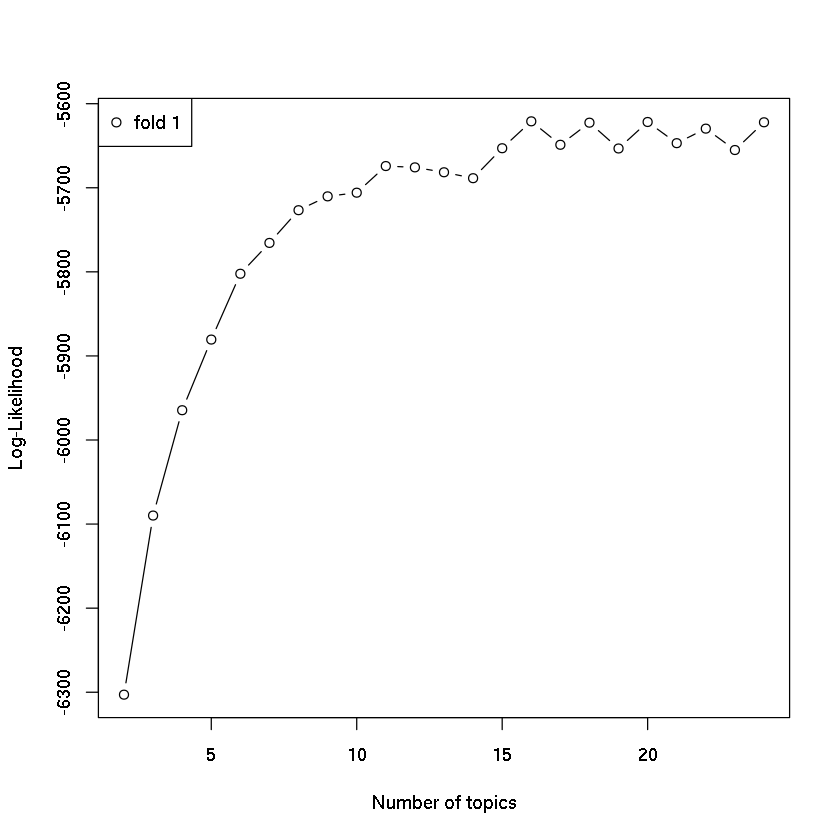

In [23]:
# 跑個模擬，挑一個好的主題數
m_per=apply(ctmK[[1]],1,mean)
m_log=apply(ctmK[[2]],1,mean)

k=c(kv_num)
#df = ctmK[[1]]  # perplexity matrix
logLik = ctmK[[2]]  # perplexity matrix

# matplot(k, df, type = c("b"), xlab = "Number of topics", 
#         ylab = "Perplexity", pch=1:try_num,col = 1, main = '')       
# legend("topright", legend = paste("fold", 1:try_num), col=1, pch=1:try_num) 
matplot(k, logLik, type = c("b"), xlab = "Number of topics", 
        ylab = "Log-Likelihood", pch=1:try_num,col = 1, main = '')       
legend("topleft", legend = paste("fold", 1:try_num), col=1, pch=1:try_num) 

In [24]:
# 現成有四種調法
k = which(logLik ==max(logLik))+1
SEED <- 2015
jss_TM2 <- list(
  VEM = LDA(dtm, k = k, control = list(seed = SEED)),
  VEM_fixed = LDA(dtm, k = k, control = list(estimate.alpha = FALSE, seed = SEED)),
  Gibbs = LDA(dtm, k = k, method = "Gibbs", 
              control = list(seed = SEED, burnin = 1000, thin = 100, iter = 1000)),
  CTM = CTM(dtm, k = k, 
            control = list(seed = SEED, var = list(tol = 10^-4), em = list(tol = 10^-3))) )   
# terms(模型,要的文字數)
termsForSave1<- terms(jss_TM2[["VEM"]], 10)
termsForSave2<- terms(jss_TM2[["VEM_fixed"]], 10)
termsForSave3<- terms(jss_TM2[["Gibbs"]], 10)
termsForSave4<- terms(jss_TM2[["CTM"]], 10)

In [25]:
#'topic graphs'
#tfs = as.data.frame(termsForSave1, stringsAsFactors = F);tfs
tfs = as.data.frame(termsForSave2, stringsAsFactors = F);tfs
#tfs = as.data.frame(termsForSave3, stringsAsFactors = F);tfs
#tfs = as.data.frame(termsForSave4, stringsAsFactors = F);tfs

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16
1,chen,audrey,數據,社會,他,致力,懷中,research,共同,產學,學習,kkbox,big,都,更,統計
2,university,gv,大,流行病學,臺灣大學,,許,ibm,用,製造,機器,華人,king,喜歡,gogolook,鄭
3,research,perl,with,社會科學,多項,化,以,ieee,創辦人,清華,副教授,產品,sc,現,各種,statistical
4,taiwan,first,阿里巴巴,地理,巨量,its,多媒體,big,r,醫院,工程系,打造,learning,chang,數學,數學系
5,ms,contributor,集團,對,認知,創代,工作,analytics,tw,多項,田,屬於,education,helen,獅,加州大學
6,chao,language,university,他,來,有限公司,r,columbia,亦,台大,線上,優秀,prof,一切,爬山,所長
7,between,taiwan,min,遊戲,會議,科技股份,視覺,distinguished,選舉,和,林軒,經理,research,不可或缺,攻城,statistics
8,skywatch,cloud,object,探勘,黃,telematics,user,university,foundi,合作,他,運用,computing,事物,算,清水
9,national,working,sun,大千,從仁,保送,交大,dr,推薦,產業,基礎,產業,香港中文大學,修剪,都,association
10,graphics,technologies,nthu,空間,智慧,創辦,group,computing,崔殷豪,簡禎,技術顧問,網羅,degree,偏見,熱愛,期刊


In [32]:
adjacent_list = lapply(1:10, function(i) embed(tfs[,i], 2)[, 2:1]) 
edgelist = as.data.frame(do.call(rbind, adjacent_list), stringsAsFactors =F)
topic = unlist(lapply(1:10, function(i) rep(i, 9)))
edgelist$topic = topic
g <-graph.data.frame(edgelist,directed=T )
l<-layout.fruchterman.reingold(g)
# edge.color="black"
nodesize = centralization.degree(g)$res 
V(g)$size = log( centralization.degree(g)$res )

nodeLabel = V(g)$name
E(g)$color =  unlist(lapply(sample(colors()[26:137], 10), function(i) rep(i, 9)));#unique(E(g)$color)

png(  paste(getwd(), "/images/topic_graph_gibbs.png", sep=""), width=10, height=10, units="in", res=700)
plot(g, vertex.label= nodeLabel,  edge.curved=TRUE, vertex.label.cex =1.25,  edge.arrow.size=0.2, layout=l)
dev.off()

pdf 
  2

![topic_graph](images/topic_graph_gibbs.png)

### 下面為上手連結
[Ref 1: 宋詞主題分析](http://computational-communication.com/post/wen-ben-wa-jue/2013-09-27-topic-modeling-of-song-peom)  
[Ref 2: JiebaR](http://qinwenfeng.com/jiebaR/index.html)  
[Ref 3: 主題模型函數- 朱雪寧](http://cos.name/2013/08/something_about_weibo/)  